In [1]:
# Import libraries that I might use.
import pandas as pd
import numpy as np
import json
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')

# Introduction

Based on the data collected by a friend, I will perform a clustering analysis of NBA player's stats based on the average of all their games last season. Follow the data extraction process at https://github.com/joeyjira/9Cat

# Explaining the Data
ppg = points per game
<br>
rpg = rebounds per game
<br>
apg = assists per game
<br>
topg = turnovers per game
<br>
spg = steals per game
<br>
bpg = blocks per game
<br>
fgp = field goal percentage
<br>
ftp = free throw percentage
<br>
tpmg = three points made per game


# Miscellaneous Explanations

Although the dataset will end up looking small (395, 12), it is only because the 395 NBA players from last year have had their 82 game regular season performances averaged out. So in reality, it should be 32,390 rows max since there are players that have missed out on games due to injury or sickness. Measuring the average than separate instances will rule out the possibility of the model selecting outlier performances of individual players and giving out false results. 
<br>
## Minor Stats Analysis
I'm going to assume that I have a normal distribution of data based on the fact that my sample size is already greater than 30 instances and I will also normalize the data further on in order to scale the data appropriately in order to conduct proper clustering. It is important to assume normality in data in order to utilize the data and the conclusions that I will draw from using the models that I will create.
<br>

## Use Case of data
The use case of conducting this personal project is to help players in this upcoming 2019 season decide on who to draft as part of their team besides the usual marquee players based on a clustering analysis of the most similar players. I have chosen to look for players that have similar performances since it's my hypothesis that similar performances will yield to picking up players that have the potential to become impressive marquee players but the results will be seen by the end of the upcoming season. 


In [2]:
# Import data
with open('stats.json') as data_file:
    d = json.load(data_file)
print(d)

{'stats': [{'ppg': 13.9, 'rpg': 9.5, 'apg': 1.6, 'topg': 1.7, 'spg': 1.5, 'bpg': 1, 'fgp': 59.5, 'ftp': 50, 'tpmpg': 0, 'firstName': 'Steven', 'lastName': 'Adams', 'pos': 'C'}, {'ppg': 8.9, 'rpg': 7.3, 'apg': 2.2, 'topg': 1.5, 'spg': 0.9, 'bpg': 0.8, 'fgp': 57.6, 'ftp': 73.5, 'tpmpg': 0.036585365853658534, 'firstName': 'Bam', 'lastName': 'Adebayo', 'pos': 'C-F'}, {'ppg': 1.7, 'rpg': 1, 'apg': 0.3, 'topg': 0.3, 'spg': 0, 'bpg': 0.2, 'fgp': 30.6, 'ftp': 100, 'tpmpg': 0.3157894736842105, 'firstName': 'Deng', 'lastName': 'Adel', 'pos': 'F'}, {'ppg': 21.3, 'rpg': 9.2, 'apg': 2.4, 'topg': 1.8, 'spg': 0.5, 'bpg': 1.3, 'fgp': 51.9, 'ftp': 84.7, 'tpmpg': 0.12345679012345678, 'firstName': 'LaMarcus', 'lastName': 'Aldridge', 'pos': 'C-F'}, {'ppg': 5.6, 'rpg': 0.6, 'apg': 0.7, 'topg': 0.9, 'spg': 0.2, 'bpg': 0.2, 'fgp': 37.6, 'ftp': 75, 'tpmpg': 0.8421052631578947, 'firstName': 'Grayson', 'lastName': 'Allen', 'pos': 'G'}, {'ppg': 10.9, 'rpg': 8.4, 'apg': 1.4, 'topg': 1.3, 'spg': 0.5, 'bpg': 1.5, '

Here, it can be seen that the data inside needs to be parsed.

In [3]:
# Parse the data.
nba_data = json_normalize(d, 'stats')
print(nba_data)

       apg   bpg    fgp  firstName     ftp       lastName  pos    ppg    rpg  \
0     1.60  1.00  59.50     Steven   50.00          Adams    C  13.90   9.50   
1     2.20  0.80  57.60        Bam   73.50        Adebayo  C-F   8.90   7.30   
2     0.30  0.20  30.60       Deng  100.00           Adel    F   1.70   1.00   
3     2.40  1.30  51.90   LaMarcus   84.70       Aldridge  C-F  21.30   9.20   
4     0.70  0.20  37.60    Grayson   75.00          Allen    G   5.60   0.60   
5     1.40  1.50  59.00    Jarrett   70.90          Allen    C  10.90   8.40   
6     4.00  0.20  46.10     Kadeem   77.80          Allen    G   9.90   2.70   
7     1.30  0.40  43.30  Al-Farouq   86.70          Aminu    F   9.40   7.50   
8     3.00  0.90  54.30       Kyle   57.80       Anderson    F   8.00   5.80   
9     5.90  1.50  57.80    Giannis   72.90  Antetokounmpo    F  27.70  12.50   
10    0.00  0.00   0.00     Kostas   50.00  Antetokounmpo    F   1.00   0.50   
11    0.70  0.30  45.30         OG   58.

In [4]:
# Take a look at the total size of the data.
nba_data.shape

(395, 12)

In [5]:
# Understand what the 12 columns are based on the current frame.
nba_data.head()

,apg,bpg,fgp,firstName,ftp,lastName,pos,ppg,rpg,spg,topg,tpmpg
0,1.6,1.0,59.5,Steven,50.0,Adams,C,13.9,9.5,1.5,1.7,0.000000
1,2.2,0.8,57.6,Bam,73.5,Adebayo,C-F,8.9,7.3,0.9,1.5,0.036585
2,0.3,0.2,30.6,Deng,100.0,Adel,F,1.7,1.0,0.0,0.3,0.315789
3,2.4,1.3,51.9,LaMarcus,84.7,Aldridge,C-F,21.3,9.2,0.5,1.8,0.123457
4,0.7,0.2,37.6,Grayson,75.0,Allen,G,5.6,0.6,0.2,0.9,0.842105


# Data Cleaning

Based on the clean data that I've already obtained, it's clear that all the columns are in numeric form except for player names and player positions. Given that the player position might be important to the clustering, I will hot encode the categorical data accordingly. 

It is also important to cocatenate the first and last name as well as to reduce confusion and make the data set a bit cleaner.

In [6]:
# Make sure there are no missing values
nba_data.isnull().values.any()

False

In [7]:
# Concatenate the first and last names 
nba_data['FullName'] = nba_data['firstName'] + ' ' + nba_data['lastName']

# Make sure that there aren't any errors by showing the list
nba_data.head()

,apg,bpg,fgp,firstName,ftp,lastName,pos,ppg,rpg,spg,topg,tpmpg,FullName
0,1.6,1.0,59.5,Steven,50.0,Adams,C,13.9,9.5,1.5,1.7,0.000000,Steven Adams
1,2.2,0.8,57.6,Bam,73.5,Adebayo,C-F,8.9,7.3,0.9,1.5,0.036585,Bam Adebayo
2,0.3,0.2,30.6,Deng,100.0,Adel,F,1.7,1.0,0.0,0.3,0.315789,Deng Adel
3,2.4,1.3,51.9,LaMarcus,84.7,Aldridge,C-F,21.3,9.2,0.5,1.8,0.123457,LaMarcus Aldridge
4,0.7,0.2,37.6,Grayson,75.0,Allen,G,5.6,0.6,0.2,0.9,0.842105,Grayson Allen


In [8]:
# Remove the former name columns.
del nba_data['firstName']
del nba_data['lastName']

# Observe results once again
nba_data.head()

,apg,bpg,fgp,ftp,pos,ppg,rpg,spg,topg,tpmpg,FullName
0,1.6,1.0,59.5,50.0,C,13.9,9.5,1.5,1.7,0.000000,Steven Adams
1,2.2,0.8,57.6,73.5,C-F,8.9,7.3,0.9,1.5,0.036585,Bam Adebayo
2,0.3,0.2,30.6,100.0,F,1.7,1.0,0.0,0.3,0.315789,Deng Adel
3,2.4,1.3,51.9,84.7,C-F,21.3,9.2,0.5,1.8,0.123457,LaMarcus Aldridge
4,0.7,0.2,37.6,75.0,G,5.6,0.6,0.2,0.9,0.842105,Grayson Allen


In [9]:
# Find out the unique values of position.
list(nba_data['pos'].unique())

['C', 'C-F', 'F', 'G', 'G-F', 'F-G', 'F-C']

There are 7 unique positions in total.

In [10]:
# Check the type of data in the data frame.
nba_data.dtypes

apg         float64
bpg         float64
fgp         float64
ftp         float64
pos          object
ppg         float64
rpg         float64
spg         float64
topg        float64
tpmpg       float64
FullName     object
dtype: object

It's interesting that position is an object rather than a string but it shouldn't hinder the transformation process for it to become a numerical variable.

In [11]:
# Transform names into numerical format
model_encoder = LabelEncoder().fit(nba_data['FullName'])

# Store in a new column
nba_data['encoded_name'] = model_encoder.transform(nba_data['FullName'])

In [12]:
# Use this as another way to keep track of player and row number.
nba_data['RowCount'] = range(len(nba_data))

In [13]:
# Transform unique positions into numerical format
model_encoder2 = LabelEncoder().fit(nba_data['pos'])

# Store in a new column
nba_data['encoded_pos'] = model_encoder2.transform(nba_data['pos'])

In [14]:
nba_data['FullName']

0               Steven Adams
1                Bam Adebayo
2                  Deng Adel
3          LaMarcus Aldridge
4              Grayson Allen
5              Jarrett Allen
6               Kadeem Allen
7            Al-Farouq Aminu
8              Kyle Anderson
9      Giannis Antetokounmpo
10      Kostas Antetokounmpo
11                OG Anunoby
12          Ryan Arcidiacono
13              Trevor Ariza
14             D.J. Augustin
15             Deandre Ayton
16              Dwayne Bacon
17         Marvin Bagley III
18                Lonzo Ball
19                  Mo Bamba
20           Harrison Barnes
21               Will Barton
22          Keita Bates-Diop
23             Nicolas Batum
24               Aron Baynes
25             Kent Bazemore
26              Bradley Beal
27             Malik Beasley
28           Marco Belinelli
29               Jordan Bell
               ...          
365           Nikola Vucevic
366            Moritz Wagner
367             Dion Waiters
368           

# Data Exploration


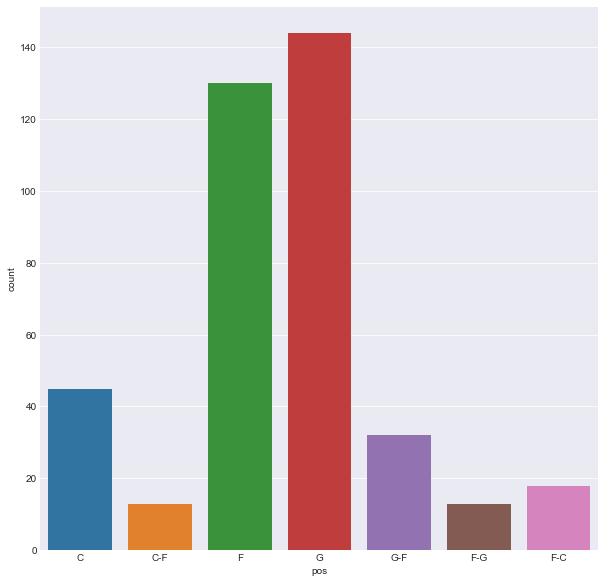

In [13]:
# Set plot size
plt.figure(figsize=(10, 10))
# Take a look at the distribution of position types in the data set.

pos_count = sns.countplot(x="pos", data=nba_data)

It can be seen that the league is dominated by mainly guards and forwards so it's most likely that the result of the clustering will show a majority of guards being clustered together.

In [20]:
# Get the average of each category
nba_data.describe()

,apg,bpg,fgp,ftp,ppg,rpg,spg,topg,tpmpg,encoded_pos
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,2.218692,0.472785,45.526498,73.622447,10.132321,4.188692,0.707595,1.240506,1.019675,3.268354
std,1.868993,0.440832,8.005695,13.276229,6.192952,2.594065,0.412283,0.812402,0.826589,1.908806
min,0.000000,0.000000,0.000000,0.000000,0.900000,0.400000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.200000,41.275000,68.300000,5.675000,2.300000,0.400000,0.600000,0.333333,2.000000
50%,1.600000,0.400000,44.500000,76.250000,8.800000,3.700000,0.600000,1.100000,0.879310,3.000000
75%,3.000000,0.600000,49.150000,82.150000,13.600000,5.275000,0.900000,1.600000,1.535712,5.000000
max,10.700000,2.700000,71.600000,100.000000,36.100000,15.600000,2.200000,5.000000,5.130435,6.000000


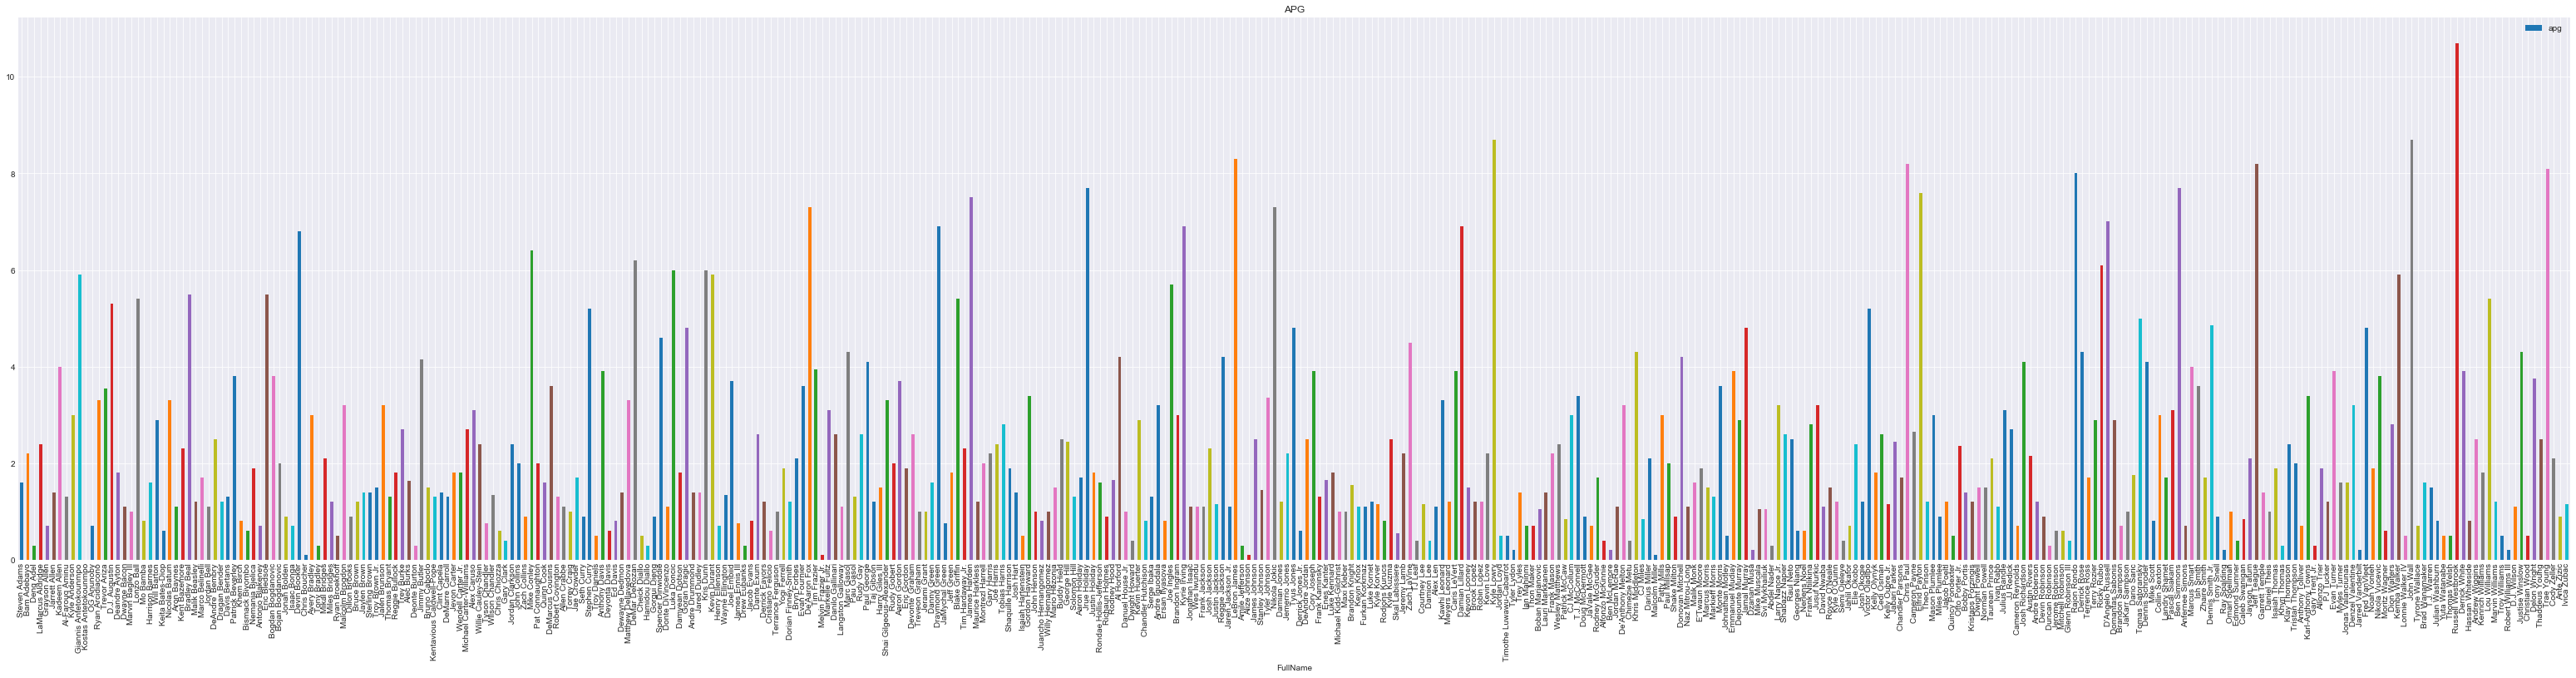

In [40]:
# Plot assists per game
nba_data.plot(kind='bar', x='FullName', y='apg',figsize=(55, 12), title='APG')
plt.show()

Seaborn didn't like the format of the FullName column and refused to plot so I decided to show graphs using another format. It can be seen that there is only one exceptional player that averages 10 assists a game (WB probably), but I have another idea for showing the strongest performer for each category.

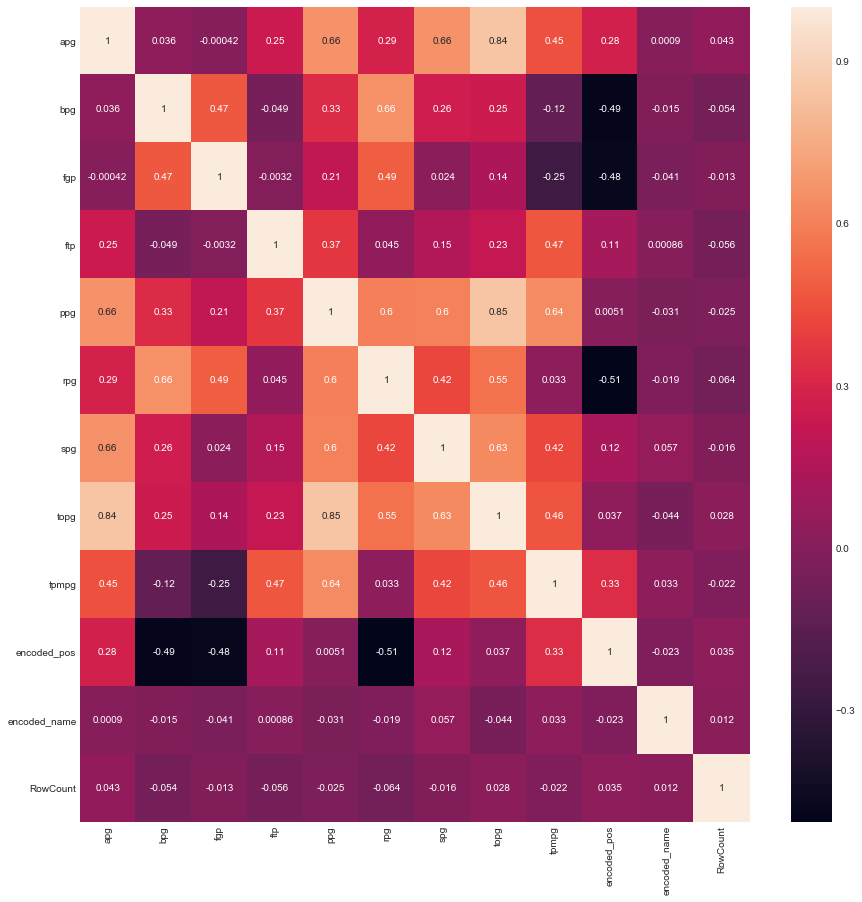

In [20]:
# Set plot size
plt.figure(figsize=(15,15))

# Create a heatmap to see if any of the columns show multicollinearity.
sns.heatmap(nba_data.corr(), annot=True)
plt.show()

Here it can be seen that not many variables share too much variance with each other. That is a good thing but it can also be seen that not that the columns themselves do not possess much variance in the first place so that may put a dent in the clustering process.
<br>
It can also be seen that the encoded names and the row numbers don't share much variance with each other either which is something I was slightly worried about, but now I know that I can keep both in and it shouldn't affect the clusters and it will be easier to cross reference my players with the row numbers. 


# K- Means 

Before using k-means, I will first normalize the data in order to make sure that the data isn't skewed and that the clustering will be as accurate as possible as I try to identify the most similar players.

In [15]:
# Create a data set specifically for clustering.
kmn_data = nba_data.drop(['pos', 'FullName'], axis=1)

In [16]:
kmn_data

,apg,bpg,fgp,ftp,ppg,rpg,spg,topg,tpmpg,encoded_name,RowCount,encoded_pos
0,1.60,1.00,59.50,50.00,13.90,9.50,1.50,1.70,0.000000,344,0,0
1,2.20,0.80,57.60,73.50,8.90,7.30,0.90,1.50,0.036585,25,1,1
2,0.30,0.20,30.60,100.00,1.70,1.00,0.00,0.30,0.315789,91,2,2
3,2.40,1.30,51.90,84.70,21.30,9.20,0.50,1.80,0.123457,244,3,1
4,0.70,0.20,37.60,75.00,5.60,0.60,0.20,0.90,0.842105,149,4,5
5,1.40,1.50,59.00,70.90,10.90,8.40,0.50,1.30,0.075000,179,5,0
6,4.00,0.20,46.10,77.80,9.90,2.70,0.80,1.40,0.894737,216,6,5
7,1.30,0.40,43.30,86.70,9.40,7.50,0.80,0.90,1.185185,4,7,2
8,3.00,0.90,54.30,57.80,8.00,5.80,1.30,1.40,0.209302,238,8,2
9,5.90,1.50,57.80,72.90,27.70,12.50,1.30,3.70,0.722222,144,9,2


It changed names into a hot encoded format which means that rather than using names as an index per row, the encoder chose to give each name a specific value to represent the row.

In [17]:
# Create variables and prepare to normalize and apply PCA on data.
X = kmn_data.iloc[:, :11]
y = kmn_data.iloc[:, 11].reshape(-1, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


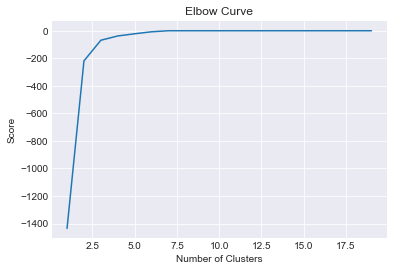

In [18]:
# Determine the optimal amount of clusters normalized
Nc = range(1, 20)

# Run through the number of clusters for kmeans
kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

# Fit and score the data.
k_score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]

k_score


# Plot the graph to see what the optimal clusters are.
plt.plot(Nc,k_score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Here, it can be seen that the normalized data only needs about 8 clusters to differentiate the players which isn't optimal, but let's give it a try before tuning the data further. Let see what the optimal components are for PCA.

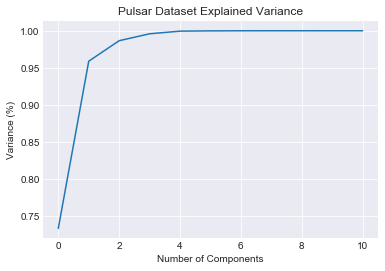

In [19]:
# Normalize X
X_norm = normalize(X)

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_norm)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

Optimal amount of components that maximize variance after normalizing data is 3 components.

In [20]:
# Import kmeans with optimal amount of cluster
kmeans = KMeans(n_clusters=8)

# Fit the normalized data
kmeans.fit(X_norm)

# Predict kmeans
y_kmeans = kmeans.predict(X_norm)

In [23]:
# Obtain the optimal amount of components.
pca = PCA(n_components=3)

# Fit the normalized data into it.
X_pca = pca.fit_transform(X_norm)

In [22]:
# Import kmeans with optimal amount of cluster
kmeans = KMeans(n_clusters=8)

# Fit the normalized data
kmeans.fit(X_pca)

# Predict kmeans
y_kmeans = kmeans.predict(X_pca)

Comparing k-means clusters against the data:


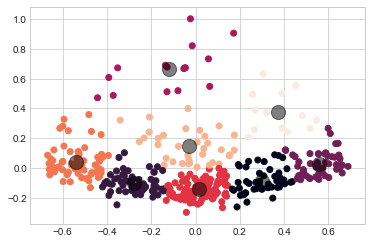

In [29]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=8, random_state=42).fit_predict(X_pca)

# Plot the solution.
sns.set_style('whitegrid')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred);

# Plot centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')

Results aren't looking too bad but let's see what the data really means. It seems that one of the clusters don't predict that well and it seems that its' function is only to carry the outliers.